In [1]:
import os 
import json 
import pandas as pd 
import polars as pl 
import numpy as np
from tqdm import tqdm 
import time 
from datetime import timedelta

import sys
import os

current_dir = os.getcwd()  # Se in notebook
src_path = os.path.abspath(os.path.join(current_dir, '..', 'src'))

if src_path not in sys.path:
    sys.path.append(src_path)

from pumps_selector import circular_right_shift
from lower_mpc import step_lower_mpc, LMPCDataBuffer
from upper_mpc import step_upper_level, UMPCDataBuffer


%load_ext autoreload
%autoreload 2

In [2]:
#time = pl.read_parquet(os.path.join(data_path_wsl, "sim_data/sim_data_1h_full.par"))
#upper_mpc_data_pan = pl.read_parquet(os.path.join(data_path_wsl, "sim_data/sim_data_1h_full.par"))
#p1= pl.read_parquet("/home/alqua/data/data_vdfs/pump1_power_siso.par").group_by_dynamic(index_column="time", every="1h").agg(pl.col("pump1_power").mean())
#p4= pl.read_parquet("/home/alqua/data/data_vdfs/pump4_power_siso.par").group_by_dynamic(index_column="time", every="1h").agg(pl.col("pump4_power").mean())
#p3= pl.read_parquet("/home/alqua/data/data_vdfs/pump3_power_siso.par").group_by_dynamic(index_column="time", every="1h").agg(pl.col("pump3_power").mean())
#pumps_df = p1.join(p4, on="time").join(p3, on="time")
#baseline_df = (pumps_df.group_by("hours").agg(
#                    pl.col("energy_cons").mean().alias("mean_energy_cons"),
#                    pl.col("energy_cons").std().alias("std_energy_cons")
#                ).sort("hours"))

In [3]:
data_path_wsl = "/home/alqua/data/pump_station_data/"
data = pl.read_parquet('/home/alqua/papers/mbs_flexibility_mpc_rev_v1/mpc/input_data/aggregated_data_for_mpc.par')

In [4]:
start_date = pd.to_datetime("2023-02-10 00:00:00+00:00")
end_date = pd.to_datetime("2023-02-28 14:00:00+00:00")

data = data.filter((pl.col("time") >= start_date) & 
                   (pl.col("time") <= end_date)
                  ).with_columns(
                      pl.col("CO2Emission")/1000, #Kg/Kwh
                      pl.col("price")/1000 # 90 eur/ton -> 0.09eur per kg
                  )

data = data.with_columns(
    # Add Danish grid & tax surcharge: 0.166 EUR/kWh per element (business, 2024, excl. VAT)
    (pl.col("price") + 0.166), 
    (pl.col("CO2Emission") * 0.09))



In [5]:
new_cols_map = {
    'time': 'time_utc',
    'inflow': 'inflow_kf', 
    'inflow_0.1': 'inflow_q10', 
    'inflow_0.5': 'inflow_q50', 
    'inflow_0.9': 'inflow_q90', 
    'price': 'da_price',
    'CO2Emission': 'co2_progn'}

data = data.select(new_cols_map).rename(new_cols_map)


In [6]:
with open('../input_data/lower_mpc_coefficients.json', 'r') as json_file:
    models_coefficients = json.load(json_file)

In [7]:
slice_df = data.select(pl.col(["time_utc", "inflow_kf", "co2_progn","da_price", 'inflow_q10', 'inflow_q50','inflow_q90']))
inflow_kf = slice_df["time_utc", "inflow_kf"].upsample(every="1m", time_column= "time_utc").fill_null(strategy="forward")["inflow_kf"]

In [8]:
lmpc_data = LMPCDataBuffer()
umpc_data = UMPCDataBuffer()
lmpc_data.initialize()



zs = 3 
N = 60
horizon = 24
step_size = 1
start_index = 0
trigger = [0, 1, 0]


#height_references = [142, 180, 200, 120, 70, 130, 150, 190, 90, 130, 195, 70, 170, 120, 150, 70]
height_references = [
    140, 180, 200, 120, 70, 130, 150, 190, 90, 130, 
    195, 70, 170, 120, 150, 70, 160, 110, 200, 80, 
    185, 140, 110, 70, 70, 130, 180, 200
]

for start_index in tqdm(range(0,len(height_references)-1)):

    height_ref = height_references[start_index]
    if start_index % 6 == 0 and start_index != 0:

        trigger = circular_right_shift(trigger)

    for k in range(0, 60):
                u_stack = np.vstack([lmpc_data.data["u1"][-zs:],
                                    lmpc_data.data["u2"][-zs:], 
                                    lmpc_data.data["u3"][-zs:]])

                power_stack = np.vstack([lmpc_data.data["p1_power"][-zs:],
                                        lmpc_data.data["p3_power"][-zs:], 
                                        lmpc_data.data["p4_power"][-zs:]])
                
                start_time_lmpc = time.time()

                start_time_lmpc =  time.time()
                res_dict  = step_lower_mpc(Qin_est = inflow_kf[start_index + k : start_index + k + 63], # da cambiare
                                        Qout_meas = lmpc_data.data["qout"][-zs:],
                                        h_meas = lmpc_data.data["height_sys"][-zs:],
                                        w_meas = u_stack,
                                        E_meas = power_stack,
                                        P_meas = lmpc_data.data["pressure_sys"][-zs:],
                                        h_ref = height_ref,
                                        trigger = trigger,
                                        N = 60,
                                        zs = zs,
                                        models_coefficients = models_coefficients)

                end_time_lmpc = time.time() - start_time_lmpc
                res_dict["opt_time_lmpc"] = end_time_lmpc
                res_dict['time_utc'] = slice_df["time_utc"][start_index] + timedelta(minutes=k)
                res_dict['height_ref'] = height_ref
                res_dict['qin'] = inflow_kf[start_index + k : start_index + k + 1][0] # access value form the list           
                lmpc_data.update(res_dict)

data = lmpc_data.to_dataframe(save=True, file_path='../output_data/lmpc_rain_shift_results.par')

  0%|          | 0/27 [00:00<?, ?it/s]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



100%|██████████| 27/27 [11:10<00:00, 24.85s/it]


In [10]:
data = data[200:]

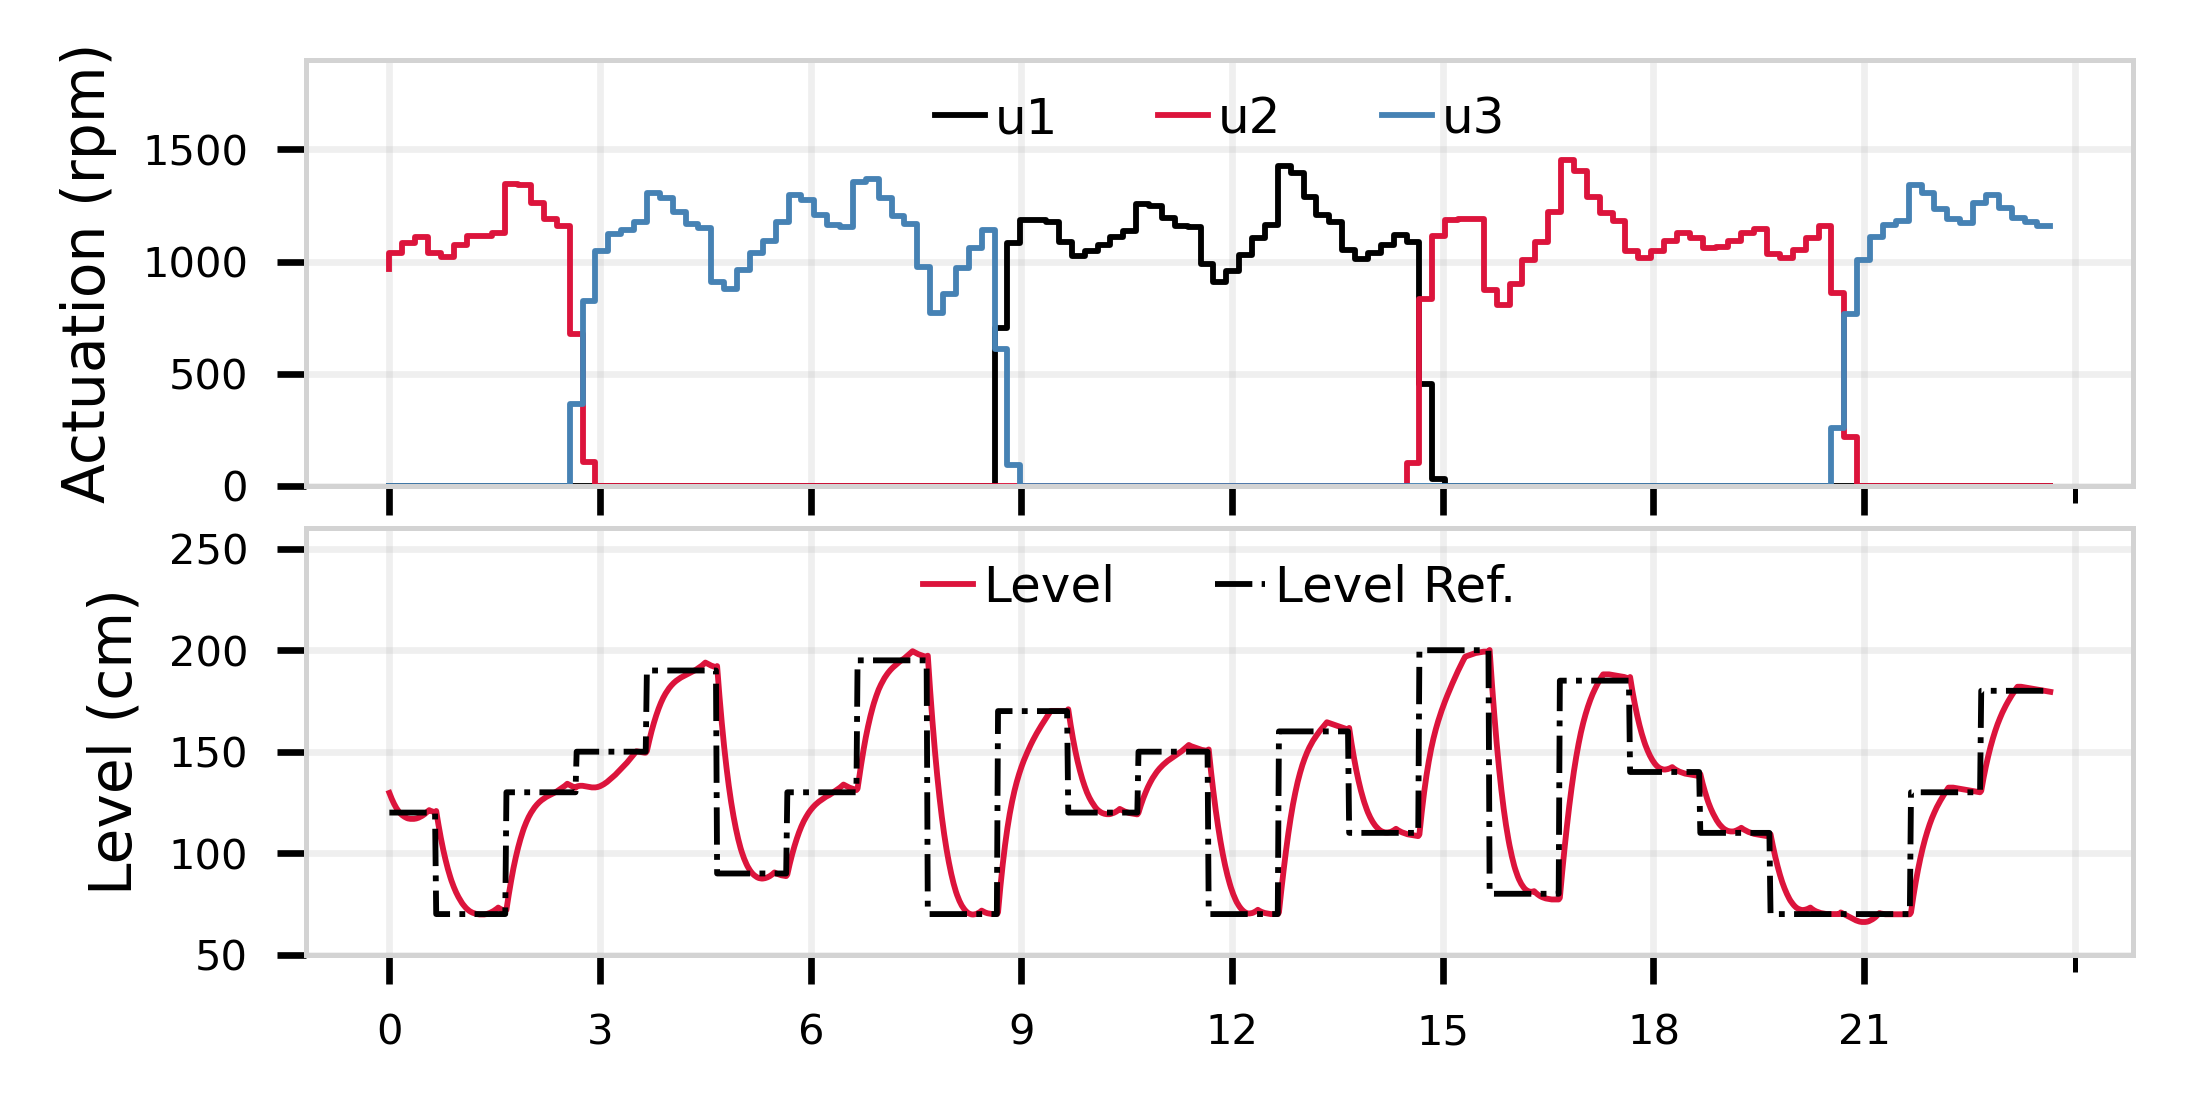

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import warnings
import polars as pl 
import matplotlib.pyplot as plt 
import scienceplots
from matplotlib.ticker import AutoMinorLocator

warnings.filterwarnings('ignore', module='matplotlib')
plt.style.use('ieee')

#===============================#
#         GLOBAL STYLE          #
#===============================#
FONT_SIZE_LABEL    = 7
FONT_SIZE_TITLE    = 7
FONT_SIZE_TICKS    = 5
FONT_SIZE_LEGEND   = 6
FONT_SIZE_XLABEL   = 6  
AXIS_LABEL_WEIGHT  = 'normal'
LINEWIDTH          = 0.7
LABELPAD           = 3
MARKERSIZE         = 2

LEGEND_PARAMS = dict(
    fontsize=FONT_SIZE_LEGEND,  # can reduce this too!
    frameon=False, fancybox=True,
    edgecolor='white', framealpha=1,
    handlelength=1,          # or even 0.8
    handletextpad=0.2,
    borderpad=0.5,
    labelspacing=0.3,
    borderaxespad=0.2
)

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': 'DejaVu Sans',
    'font.size': 16,
    'pdf.fonttype': 42,
    'axes.labelsize': FONT_SIZE_LABEL,
    'axes.labelweight': AXIS_LABEL_WEIGHT,
    'axes.titlesize': FONT_SIZE_TITLE,
    'xtick.labelsize': FONT_SIZE_TICKS,
    'ytick.labelsize': FONT_SIZE_TICKS,
    'legend.fontsize': FONT_SIZE_LEGEND,
    'lines.linewidth': 1,
    'lines.markersize': MARKERSIZE,
    
})

#=========================#
#      PLOTTING LAYOUT    #
#=========================#
fig, axs = plt.subplots(
    2, 1,
    figsize=(3.5, 1.7),  # Adjusted height accordingly
    gridspec_kw=dict(height_ratios=[1, 1]),
    sharex=True,
)

t = np.arange(0,len(data['u1']))
#----- Top panel -----#
downsample_factor = 11
t_down = t[::downsample_factor]
u1_down = data['u1'][::downsample_factor]
u2_down = data['u2'][::downsample_factor]
u3_down = data['u3'][::downsample_factor]

ax1 = axs[0]
ax1.step(t_down, u1_down, linestyle="-", lw=LINEWIDTH, color="black", label="u1")
ax1.step(t_down, u2_down, linestyle="-", lw=LINEWIDTH, color="crimson", label="u2")
ax1.step(t_down, u3_down, linestyle="-", lw=LINEWIDTH, color="steelblue", label="u3")
ax1.set_ylabel('Actuation (rpm)', labelpad=LABELPAD, fontweight=AXIS_LABEL_WEIGHT)

ax1.legend(loc="upper center", ncols=3, **LEGEND_PARAMS)
ax1.set_ylim(0, 1900)
ax1.grid(True, zorder=0, alpha=0.3)
ax1.yaxis.set_minor_locator(AutoMinorLocator(2)) 
ax1.xaxis.set_minor_locator(AutoMinorLocator(2)) 
ax1.xaxis.set_major_formatter(DateFormatter('%d'))
plt.setp(ax1.xaxis.get_majorticklabels(), visible=True)

#----- Bottom panel (was third panel) -----#
ax2 = axs[1]
ax2.plot(data["height_sys"], color="crimson", lw=LINEWIDTH, label="Level", alpha=1)
ax2.plot(data["height_ref"], linestyle= "-.", color="k",lw=LINEWIDTH, label="Level Ref.", alpha = 1)

ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax2.set_ylim(50,260)
ax2.set_ylabel('Level (cm)', labelpad=LABELPAD, fontweight=AXIS_LABEL_WEIGHT)
ax2.legend(loc="upper center", ncols=3, **LEGEND_PARAMS)
#----- Style spines -----#
for ax in [ax1, ax2]:
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.6)
        ax.grid(True, which='major', alpha=0.2)
        ax.grid(True, which='minor', alpha=0.2)
        ax.yaxis.set_minor_locator(AutoMinorLocator(1))
        ax.xaxis.set_minor_locator(AutoMinorLocator(1))
        spine.set_color('lightgrey')

ax1.set_xticks(np.arange(0, len(data['u1']), 180)); ax1.set_xticklabels((np.arange(0, len(data['u1']), 180) / 60).astype(int))
plt.tight_layout(pad=0.1)
plt.savefig('lower_mpc_actuation.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.show()